In [1]:
!pip install -q GPy
!pip install -q flax

     |████████████████████████████████| 959 kB 19.2 MB/s 
     |████████████████████████████████| 71 kB 9.4 MB/s 
     |████████████████████████████████| 185 kB 32.2 MB/s 
     |████████████████████████████████| 237 kB 67.2 MB/s 
     |████████████████████████████████| 145 kB 66.7 MB/s 
     |████████████████████████████████| 51 kB 6.9 MB/s 
     |████████████████████████████████| 85 kB 4.1 MB/s 


In [2]:
import matplotlib.pyplot as plt
import pickle
import GPy
kernels=GPy.kern
import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import pandas as pd
from sklearn import preprocessing as sp
import optax
import seaborn as sns
from functools import partial
from sklearn import datasets

### **Loading the data & visualising it**

In [3]:
dataset = datasets.fetch_openml(data_id=41187, as_frame=True)   # load the dataset

In [4]:
dataset.frame.head()  # show the first 5 rows of the dataset

,year,month,day,weight,flag,station,co2
0,1958.0,3.0,29.0,4.0,0.0,MLO,316.1
1,1958.0,4.0,5.0,6.0,0.0,MLO,317.3
2,1958.0,4.0,12.0,4.0,0.0,MLO,317.6
3,1958.0,4.0,19.0,6.0,0.0,MLO,317.5
4,1958.0,4.0,26.0,2.0,0.0,MLO,316.4


In [5]:
df = dataset.frame
df["date"] = pd.to_datetime(df[["year", "month", "day"]])    # convert the year, month, day columns to a single date column
df = df[["date", "co2"]].set_index("date")                 # set the date column as the index

In [6]:
df.head()     # show the first 5 rows of the new changed dataset

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [7]:
df = df.resample("M").mean().dropna(axis="index", how="any")   # Removing the na points from the dataset and resampling the data

Text(0, 0.5, 'CO$_2$ concentration (ppm)')

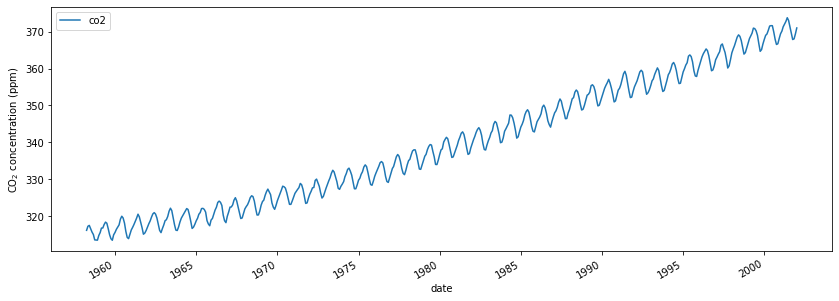

In [8]:
df.plot(figsize=(14, 5))
plt.ylabel("CO$_2$ concentration (ppm)")

In [9]:
X_original = (df.index.year + df.index.month / 12).to_numpy().reshape(-1, 1)    # converting the date column to a numpy array

In [10]:
s = 200
n = 450
scaler = sp.StandardScaler()
X=X_original[s:n]            ## Taking only points betweeen s & n for the training set
scaler = scaler.fit(X)       
x = scaler.transform(X)      ## Downscaling the dataset so that the values are within the similar value ranges so that the gradient descent converges faster

In [11]:
X_original[200],X_original[450]

(array([1975.33333333]), array([1996.16666667]))

In [12]:
Y_original = jnp.array(df["co2"])
Y=Y_original[s:n]
min_max = sp.MinMaxScaler(feature_range=(0, 5))
min_max = min_max.fit(Y.reshape(-1, 1))
y = min_max.transform(Y.reshape(-1, 1))
Y=Y.reshape(-1,1)

### **Kernel Design**

In [13]:
final_kernel=kernels.Exponential(1)+kernels.Bias(1,variance=10000.)+kernels.Linear(1)+kernels.StdPeriodic(1,period=1.)*kernels.RBF(1)

 /usr/local/lib/python3.7/dist-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Logic behind using the above mentioned kernel design:
1. To add the linear trend as seen in the data. The linear kernel was added in the summation above.
2. Bias kernel has been used to add the minimum starting point of the prediction based on the earlier data so that the predictions always start above a certain level
3. To add non linearity to the overall trend for better fit we have used the exponential kernel
4. To add periodicity to the data we have used the StdPeriodic kernel and further multiplied it with thr RBF kernel to modulate the amplitude

### **Creating the GP model**

In [14]:
GP_model = GPy.models.GPRegression(X=X, Y=Y, kernel=final_kernel)
GP_model

GP_regression.,value,constraints,priors
sum.Exponential.variance,1.0,+ve,
sum.Exponential.lengthscale,1.0,+ve,
sum.bias.variance,10000.0,+ve,
sum.linear.variances,1.0,+ve,
sum.mul.std_periodic.variance,1.0,+ve,
sum.mul.std_periodic.period,1.0,+ve,
sum.mul.std_periodic.lengthscale,1.0,+ve,
sum.mul.rbf.variance,1.0,+ve,
sum.mul.rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [15]:
GP_model.optimize_restarts(num_restarts=10)

Optimization restart 1/10, f = 81.61162567138672
Optimization restart 2/10, f = 265.90350341796875
Optimization restart 3/10, f = 82.5416488647461
Optimization restart 4/10, f = 262.9546203613281
Optimization restart 5/10, f = 265.7091064453125


 /usr/local/lib/python3.7/dist-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /usr/local/lib/python3.7/dist-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /usr/local/lib/python3.7/dist-packages/GPy/kern/src/stationary.py:213: RuntimeWarning:invalid value encountered in multiply
 /usr/local/lib/python3.7/dist-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 6/10, f = 100.92680358886719
Optimization restart 7/10, f = 414.5607604980469
Optimization restart 8/10, f = 411.69122314453125
Optimization restart 9/10, f = 391.2554931640625
Optimization restart 10/10, f = 391.5146179199219


### **Testing the model**

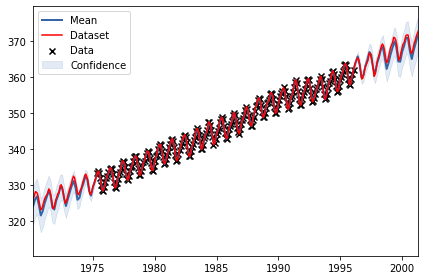

In [16]:
GP_model.plot()
plt.plot(X_original,Y_original,label="Dataset",color="red")
plt.legend()

In [17]:
X_original.shape

(521, 1)

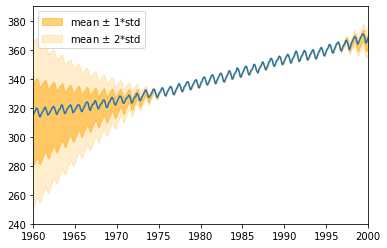

In [18]:
plt.plot(X_original,Y_original)
mean_gp,std_gp=GP_model.predict(X_original)
mean_gp=mean_gp.reshape(521,)
plt.ylim(240,390)
plt.xlim(1960,2000)
std_gp=std_gp.reshape(521,)
for i in range(1, 3):
    plt.fill_between(
        X_original.reshape(521,),
      mean_gp - i*std_gp,
      mean_gp + i*std_gp,
      color="orange",
      alpha= 1/ ((i * 3)-1),
        label=f"mean $\pm$ {i}*std")
plt.legend()

### **MC Dropout**

In [19]:
class mc_dropout(nn.Module):
    features: list

    @nn.compact
    def __call__(self, x, deterministic=True, rate=0.1):

        for i, feature in enumerate(self.features):
            x = nn.Dense(feature)(x)
            x = nn.relu(x)
            x = nn.Dropout(rate=rate, deterministic=deterministic)(x)

        x = nn.Dense(1)(x)
        return x

    def loss_fn(
        self, params, x, y, deterministic=False, rate=0.1, rng=jax.random.PRNGKey(0)):
        y_pred = self.apply(params, x, deterministic, rate, rngs={"dropout": rng})
        loss = jnp.mean((y - y_pred) ** 2)
        return loss

In [20]:
def fit(model, params, auxs, learning_rate=0.01, epochs=1000, verbose=False):
    opt = optax.adam(learning_rate=learning_rate)
    opt_state = opt.init(params)

    partial_loss_fn = partial(
        model.loss_fn, deterministic=auxs["deterministic"], rate=auxs["rate"]
    )
    loss_grad_fn = jax.jit(jax.value_and_grad(partial_loss_fn))
    losses = []
    upd = jax.jit(opt.update)
    x, y = auxs["X"], auxs["y"]
    rng = jax.random.PRNGKey(0)
    for i in range(epochs):
        rng, _ = jax.random.split(rng)
        loss_val, grads = loss_grad_fn(params, x, y, rng=rng)
        updates, opt_state = upd(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        losses.append(loss_val)
        if verbose and i % (epochs / 10) == 0:
            print("Loss step {}: ".format(i), loss_val)
    return params, jnp.array(losses)

In [21]:
model = mc_dropout(features=[256, 512, 256, 128])

In [22]:
params = model.init(jax.random.PRNGKey(0), x)

In [23]:
auxs = {"X": x, "y": y, "deterministic": False, "rate": 0.1}
params, losses = fit(
    model, params, auxs, learning_rate=0.0005, epochs=90000, verbose=True
)

Loss step 0:  7.970373
Loss step 9000:  0.07845649
Loss step 18000:  0.058705784
Loss step 27000:  0.053472925
Loss step 36000:  0.046572044
Loss step 45000:  0.038223423
Loss step 54000:  0.032517053
Loss step 63000:  0.036174674
Loss step 72000:  0.029211778
Loss step 81000:  0.026915217


In [24]:
def eval(params, x, deterministic=False, rate=0.1, rng=jax.random.PRNGKey(0)):
    return model.apply(params, x, deterministic=False, rate=0.1, rngs={"dropout": rng})

In [25]:
x_test = scaler.transform(X_original)
n_stacks = 100
y_stacks = []
partial_eval_fn = partial(eval, deterministic=False, rate=0.1)
evaluate = jax.jit(partial_eval_fn)
for i in range(n_stacks):
    r_y = evaluate(params, x_test, rng=jax.random.PRNGKey(i))
    r_y = min_max.inverse_transform(r_y)
    y_stacks.append(r_y)

In [26]:
y_stacks = jnp.array(y_stacks)

In [27]:
mean = (y_stacks.mean(axis=0)).squeeze()
std = (y_stacks.std(axis=0)).squeeze()

In [28]:
x_test = scaler.inverse_transform(x_test)

(1970.0, 2000.0)

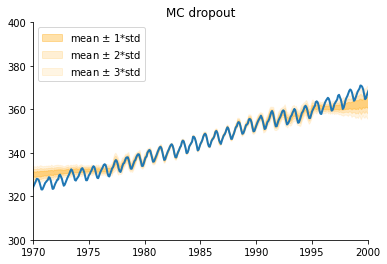

In [29]:
plt.title("MC dropout")
plt.plot(X_original, Y_original, linewidth=2)

for i in range(1, 4):
    plt.fill_between(
        x_test.squeeze(),
        mean - i * std,
        mean + i * std,
        color="orange",
        alpha=1 / (i * 3),
        label=f"mean $\pm$ {i}*std",
    )
plt.legend(loc="upper left")
sns.despine()
plt.ylim(300, 400)
plt.xlim(1970, 2000)

(1970.0, 2005.0)

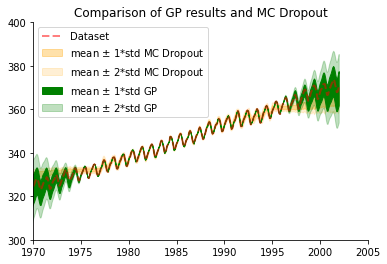

In [30]:
plt.plot(X_original, Y_original, linewidth=2,label="Dataset",color="red",linestyle="dashed",alpha=0.5)

for i in range(1, 3):
    plt.fill_between(
        x_test.squeeze(),
        mean - i * std,
        mean + i * std,
        color="orange",
        alpha=1 / ((i * 3)),
        label=f"mean $\pm$ {i}*std MC Dropout"
    )
mean_gp,std_gp=GP_model.predict(X_original)
mean_gp=mean_gp.reshape(521,)
plt.ylim(240,390)
plt.xlim(1960,2000)
std_gp=std_gp.reshape(521,)
for i in range(1, 3):
    plt.fill_between(
        X_original.reshape(521,),
      mean_gp - i*std_gp,
      mean_gp + i*std_gp,
      color="green",
      alpha= 1/ ((i * 3)-2),
        label=f"mean $\pm$ {i}*std GP")

plt.legend(loc="upper left")
sns.despine()
plt.title("Comparison of GP results and MC Dropout")
plt.ylim(300, 400)
plt.xlim(1970, 2005)